# Objetivo

O objetivo deste projeto é a realização de uma pipeline de dados utilizando um bot criado no Telegram, que capta mensagens que são enviadas em um específico grupo, e as armazena para análise utilizando um webhook entre o bot e uma API criada no AWS.

## Fluxograma

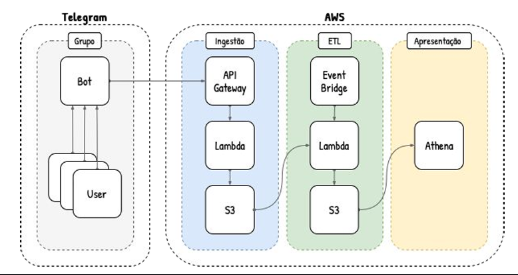

A pipeline de dados funciona da seguinte maneira:
    
 * O bot captura mensagens que são enviadas em um grupo específico no Telegram;

 * Através do webhook conectando o bot ao AWS, uma função Lambda verifica o conteúdo das mensagens, e as mesmas são enviadas à um bucket criado no sistema S3 em seu formato original JSON;

 * Com um Event Bridge programado de forma diária, uma segunda função Lambda é executada para verificar as mensagens que foram salvas no bucket S3, e às transforma em formato parquet para que possam ser consultadas e análisadas através do Athena.

## Processo

### 1. Criação do bot no Telegram

O Telegram possui um sistema que permite a criação simples e rápida de bots utilizando o BotFather. Seguindo intruções, o bot é criado, dado nome, e um token único que será utilizado para acesso às APIs.

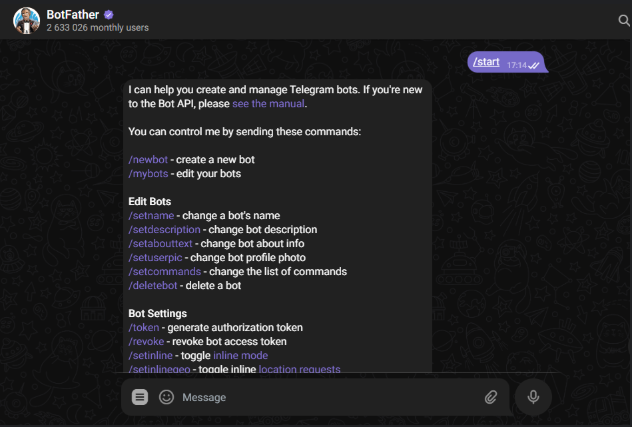

O bot é então adicionado e dado acesso de admin ao grupo para que possa captar as mensagens.

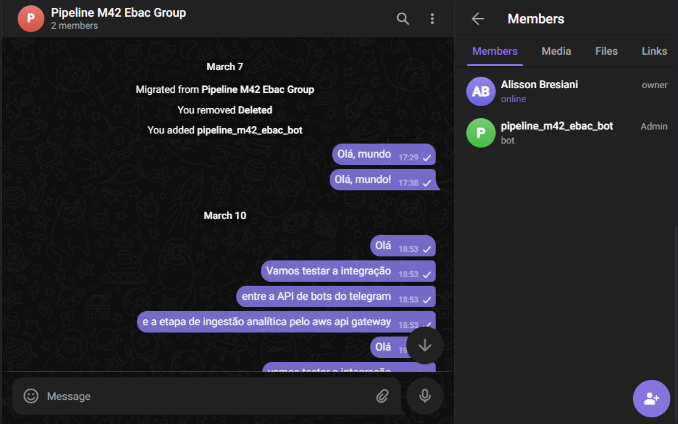

### 2 Criando o Bucket S3 e a Função Lambda

Preparando o ambiente para a pipeline de dados, será criado um bucket no S3 para que seja armazenado o dado bruto (raw) das mensagens capturadas pelo bot, assim como a função Lambda responsável pelo armazenamento destes dados.

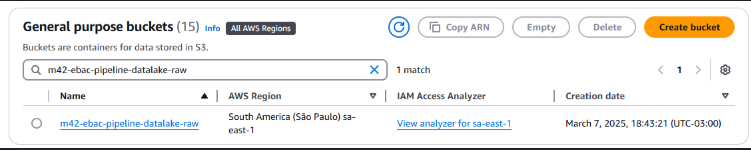

### 2.1 Criação da Função Lambda

Com a API que será criada no próximo passo, e a configuração de variávies de ambiente, o código abaixo é capaz de fazer a leitura das mensagens, confirmar se vem do grupo correto em que o bot faz parte, e salvá-las no bucket que acabou de ser criado.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3

def lambda_handler(event: dict, context: dict) -> dict:

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
    logging.error(msg=exc)
    return dict(statusCode="500")

  else:
    return dict(statusCode="200")

### 3 Configuração do API GATEWAY

Com a função Lambda criada, podemos conectar o bot do Telegram ao sistema AWS utilizando o API GATEWAY. O API criado é do tipo REST, e é criado um método do tipo POST que conecta o API ao código Lambda, e finalmente é feito o deploy de um novo estágio, que nos fornecerá a URL necessária para o webhook.

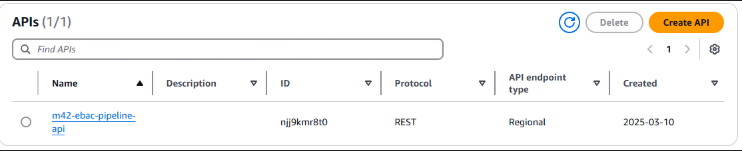

### 3.1 Webhook

Com a realização o webhook, o bot do telegram estará conectado ao sistema AWS, e as mensagens enviadas ao grupo serão armazenadas no bucket S3.

In [ ]:
# Código utilizado para a configuração do webhook

from getpass import getpass

aws_api_gateway_url = getpass()

response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

### 4 ETL

Neste passo, serão criados uma nova Função Lambda e um novo bucket S3, com o intúito de processar e armazenar de forma enriquecida, os dados que eram apenas brutos anteriormente.

### 4.1 Criação do Bucket de Dados Enriquecidos

É criado um bucket em que possam ser armazenados os dados enriquecidos processados pela nova Função Lambda.

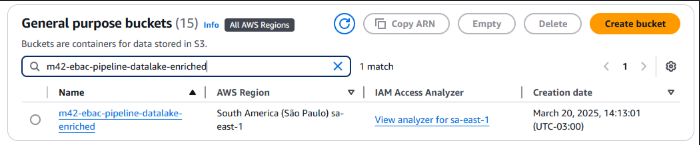

### 4.2 Função Lambda

Esta função é criada com o intúito de processar os dados brutos que foram salvos no dia anterior, de forma que o resultado é salvo em formato parquet, também particionado por dia, para fácil consulta e análise no futuro.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq

def lambda_handler(event: dict, context: dict) -> bool:

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # codigo principal

  table = None
  client = boto3.client('s3')

  try:

    response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

    for content in response['Contents']:
      key = content['Key']
      client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

      with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

        data = json.load(fp)
        data = data["message"]

      parsed_data = parse_data(data=data)
      iter_table = pa.Table.from_pydict(mapping=parsed_data)

      if table:

        table = pa.concat_tables([table, iter_table])

      else:

        table = iter_table
        iter_table = None

    pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
    client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"context_date={date}/{timestamp}.parquet")

    return True

  except Exception as exc:
    logging.error(msg=exc)
    return False

def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():
    if key == 'from':
      for k, v in data[key].items():
        if k in ['id', 'is_bot', 'first_name']:
          parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key == 'chat':
      for k, v in data[key].items():
        if k in ['id', 'type']:
          parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

    elif key in ['message_id', 'date', 'text']:
      parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

### 4.3 Event Bridge

Com a ferramenta Event Bridge no AWS, é criado uma rotina que executa o a Função Lambda acima diariamente à meia-noite, buscando manter a base de dados atualizada.

### 5 Apresentação

Para vizualição e consulta dos dados enriquecidos armezenados no bucket, é criada uma tabela no sistema Athena. Utilizando este processo, é também necessário fazer o carregamento de novas partições diariamente.

In [ ]:
# Código utilizado na criação da tabela para consulta dos dados armazenados no bucket enriquecido

CREATE EXTERNAL TABLE `telegram`(
    `message_id` bigint,
    `user_id` bigint,
    `user_is_bot` boolean,
    `ser_first_name` string,
    `chat_id` bigint,
    `chat_type` string,
    `text` string,
    `date` bigint)
PARTITIONED BY (
    `context_date` date)
ROW FORMAT serde
    'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
    'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
    'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
    's3://m42-ebac-pipeline-datalake-enriched/'


# Comando para carregamento das partições

MSCK REPAIR TABLE telegram

### 5.1 Queries

Abaixo seguem algumas queries que foram realizadas para teste:

Query: Primeiras 10 linhas da tabela

```
select * from telegram limit 10;
```

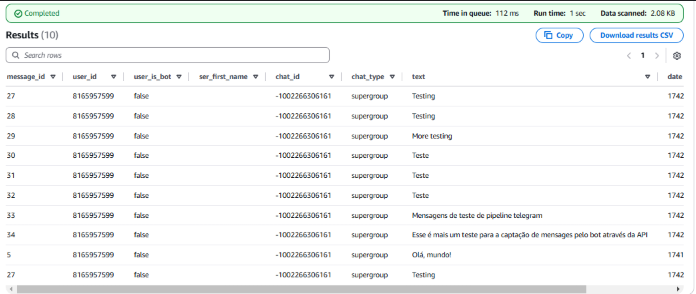

Query: Quantidade de mensagens por dia



```
select
    context_date,
    count(1) as "message_amount"
from telegram
group by context_date
order by context_date desc
```

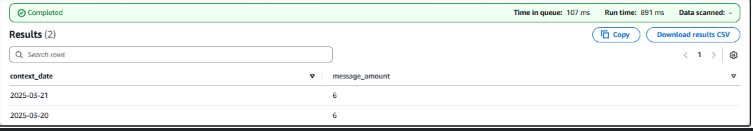

Query: Quantidade de mensagens por hora, por dia da semana, por número da semana



```
with
parsed_date_cte as(
    select
        *,
        cast(date_format(from_unixtime("date"), '%Y-%m-%d %H:%i:%s') as timestamp) as parsed_date
    from telegram
),
hour_week_cte as (
    select
        *,
        extract(hour from parsed_date) as parsed_date_hour,
        extract(dow from parsed_date) as parsed_date_weekday,
        extract(week from parsed_date) as parsed_date_weeknum
    from parsed_date_cte
)
select
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) as "message_amount"
from hour_week_cte
group by
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
order by
    parsed_date_weeknum,
    parsed_date_weekday
```

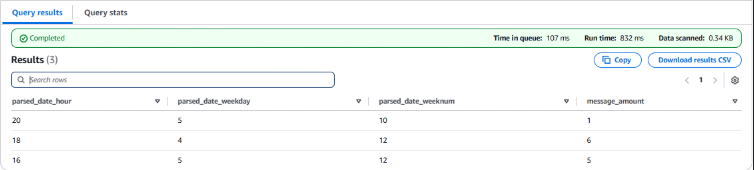